In [1]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from src.setup import *
from src.datafeed_ import *

In [2]:
# settings
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

def format_dataframe(df_: pd.DataFrame, tail=True):
    """A little formatter helper."""
    if tail:
        return format_dataframe(df_.tail(), tail=False)
    if df_.columns.nlevels > 1:
        col_key = ("date", "")
    else:
        col_key = "date"
    res_ = df_.reset_index()\
        .style.format(formatter={col_key: lambda x: x.strftime("%Y-%m-%d %H:%M")},
                      precision=2)\
        .hide(axis=0)
    return res_


# data
Spot quotes of USDRUB at 1-min frequency (GMT+1 time) are from Bloomberg. Events and their timestamps (GMT+1) are from Bloomberg.

In [9]:
# load spot data
d_spot = get_spot_data()

format_dataframe(d_spot.set_index("date"), tail=True)

date,value
2022-02-28 16:46,109.50
2022-02-28 16:47,109.61
2022-02-28 16:48,109.54
2022-02-28 16:49,107.90
2022-02-28 16:50,107.82


In [5]:
# load events data
d_events = get_timeline()

format_dataframe(d_events, tail=False)

date,event
2022-02-24 04:06,putin announces special military operation
2022-02-18 22:58,biden warns russia planning attack in coming days
2022-02-17 15:19,biden estimate prob of invasion as very high
2022-02-11 20:03,jake sullivan believes putin has decided to invade next week
2022-02-11 11:34,blinken warns russia can attack during the olympics


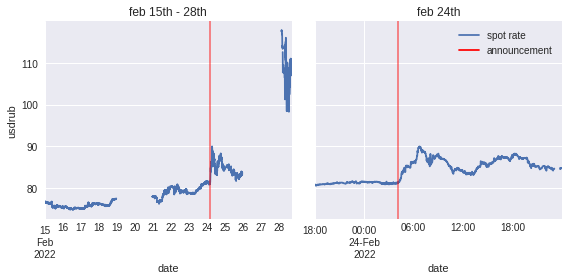

In [12]:
# plot dynamics
to_plot = d_spot.set_index("date").squeeze().rename("usdrub")
dt_t = d_events.index[0]

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0].set_title("feb 15th - 28th")
ax[0].set_ylabel("usdrub")
ax[1].set_title("feb 24th")

to_plot.loc["2022-02-15":].plot(ax=ax[0])
to_plot.loc["2022-02-23 18:00":"2022-02-24"].plot(ax=ax[1])
for ax_ in ax:
    ax_.axvline(x=dt_t, color="r", label="announcement", alpha=0.5)

# legend
leg_handles = [
    mlines.Line2D([], [], color=palette[0], label="spot rate"),
    mlines.Line2D([], [], color="r", label="announcement")
]
ax[1].legend(handles=leg_handles)

fig.tight_layout()
plt.show()